# Geometric Deep Learning Exam: Predicting Persistence Images

# Step 0: Installation and Setup

In [ ]:
#@title [RUN] Install required libraries for Deep Learning
!pip install -q torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -q networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install -q rdkit-pypi==2021.9.4
!pip install -q py3Dmol==1.8.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title [RUN] Install required libraries for Topological Data Analysis

!pip install -q Cython
!pip install -q ripser
!pip install -q persim
!pip install -q pytorch2tikz
!pip install -q tikzplotlib

In [ ]:
#@title [RUN] Import python modules

# Standard
import os
import time
import random
import numpy as np

# Geometry
from scipy.stats import ortho_group

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9, ModelNet, ShapeNet, GeometricShapes
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter
from torch.autograd import Variable

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)
        
from google.colab import files
from IPython.display import HTML

# TDA 
from ripser import Rips
from persim import PersistenceImager
from persim.images_weights import persistence, linear_ramp

from pytorch2tikz import Architecture

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 1.12.1+cu113
PyG version 2.4.0


In [ ]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Loading and Pre-processing Datase

## Precomputing persistence images

---



In [ ]:
# TDA tools
rips = Rips() # Rips complex for speed
pimgr = PersistenceImager(pixel_size=0.03125, birth_range=(0.0, 1.0), pers_range=(0.0, 1.0)) # resolution 32x32 

# Parameters to fine-tune for the dataset (no canonical choice)
pimgr.kernel_params = {'sigma': 0.01}
pimgr.weight = persistence
pimgr.weight_params = {'n': 2.0}

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [ ]:
class Select_Points(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, data):
        data.pos = data.pos[:self.output_size]
        return data

class Normalisation(object):
    def __call__(self, data):
        mean = data.pos.mean(dim=0, keepdim=True)
        std = data.pos.std(dim=0, keepdim=True)
        data.pos = data.pos - mean
        if 0 not in std:
            data.pos = data.pos / std
        return data

## Loading dataset

In [ ]:
class MyShapeNet(Dataset):
    def __init__(self, transform = None):
        super(MyShapeNet, self).__init__()
        
        path = './shapenet'
        dataset = ShapeNet(path, transform = transform)

        self.data = [(torch.Tensor(dataset[i].pos), torch.Tensor(pimgr.transform(rips.fit_transform(dataset[i].pos)[1]).flatten())) for i in range(len(dataset))]
        random.shuffle(self.data)

    def len(self):
        return len(self.data)

    def get(self, index):
        return self.data[index]

# Create an instance of the dataset
nb_points = 200 # number of points per point cloud

preprocess = T.Compose([Select_Points(nb_points), Normalisation()]) # Select_Points Reduce number of points in each point cloud to reduce computations. Normalisation of the points
dataset = MyShapeNet(transform = preprocess)

Extracting shapenet/shapenetcore_partanno_segmentation_benchmark_v0_normal.zip
Processing...
Done!


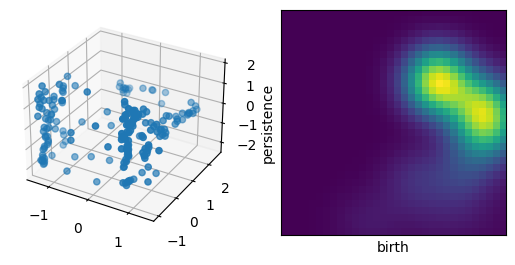

In [ ]:
#@title [RUN] Visualisation

# Pointcloud
index = 143

fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")
ax.scatter(dataset[index][0][:, 0], dataset[index][0][:, 1], dataset[index][0][:, 2])

# Persistence image (ground truth to predict)
ax = fig.add_subplot(122)
pimgr.plot_image(dataset[index][1].reshape(pimgr.resolution), ax)
plt.show()

In [ ]:
#@title [RUN] Visualisation

In [ ]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets
train_dataset = dataset[:1000]
val_dataset = dataset[1000:1500]
test_dataset = dataset[1500:2000]

print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders
train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False)

Total number of samples: 14007.
Created dataset splits with 1000 training, 500 validation, 500 test samples.


In [ ]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

## ML Helpers


In [ ]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0
    for data in train_loader:
        data_x = data[0].squeeze()
        data_y = data[1].squeeze()
        optimizer.zero_grad()
        y_pred = model(data_x)
        loss = F.mse_loss(y_pred, data_y)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data_x = data[0].squeeze()
        data_y = data[1].squeeze()
        with torch.no_grad():
            y_pred = model(data_x)
            # Mean Absolute Error
            error += F.mse_loss(y_pred, data_y).item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    epoch_best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error
            epoch_best_val_error = epoch

        elif epoch - epoch_best_val_error == 5:
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, ' f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
            perf_per_epoch.append((test_error, val_error, epoch, model_name))
            break

        if epoch % 5 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        # print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, ' f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

# Step 2: Simple MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1024, num_layers=2):
        super(MLP, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers-2)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.collapse = nn.MaxPool1d(nb_points)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        x = x.transpose(0, 1).squeeze()
        x = self.collapse(x).squeeze()
        return x

In [ ]:
model_mlp = MLP(input_dim=3, output_dim=1024, hidden_dim=64, num_layers=3)
model_name_mlp = type(model_mlp).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_mlp, 
    model_name_mlp, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
RESULTS[model_name_mlp] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MLP, training on 1000 samples for 100 epochs.

Model architecture:
MLP(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1024, bias=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 70976

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000044, Val MAE: 0.0000032, Test MAE: 0.0000030
Epoch: 010, LR: 0.001000, Loss: 0.0000019, Val MAE: 0.0000020, Test MAE: 0.0000019
Epoch: 015, LR: 0.001000, Loss: 0.0000019, Val MAE: 0.0000020, Test MAE: 0.0000018
Epoch: 017, LR: 0.001000, Loss: 0.0000019, Val MAE: 0.0000025, Test MAE: 0.0000018

Done! Training took 3.24 mins. Best validation MAE: 0.0000019, corresponding test MAE: 0.0000018.


<ipython-input-15-c7b7c1381fda>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


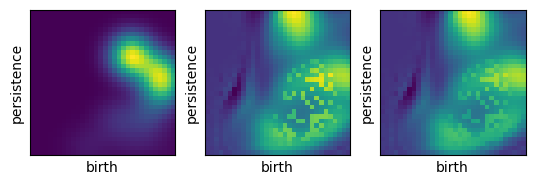

In [ ]:
#@title [RUN] Visualisation

# tikz output 
tikz = False

fig = plt.figure()
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_mlp(dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_mlp(dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/mlp_3.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

# Step 3: Distance MLP

In [ ]:
class DistanceLayer(nn.Module):
    def __init__(self, emb_size):
        super(DistanceLayer, self).__init__()
        self.emb_size = emb_size

    def forward(self, input):
        distances = torch.cdist(input, input) 
        # distances, _ = torch.sort(distances, dim=0)

        return distances.resize_(nb_points, self.emb_size)

In [ ]:
class PointInvariantModel(nn.Module):
    def __init__(self, input_dim=nb_points, output_dim=1024, hidden_dim=64, num_layers=4):
        super(PointInvariantModel, self).__init__()
        
        self.emb_layer = DistanceLayer(input_dim)
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers-2)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.collapse = nn.MaxPool1d(nb_points)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.emb_layer(x))
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        x = x.transpose(0, 1).squeeze()
        x = self.collapse(x).squeeze()
        return x

In [ ]:
model_pim = PointInvariantModel(input_dim=nb_points, output_dim=1024, hidden_dim=64, num_layers=3)
model_name_pim = type(model_pim).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_pim, 
    model_name_pim, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
RESULTS[model_name_pim] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for PointInvariantModel, training on 1000 samples for 100 epochs.

Model architecture:
PointInvariantModel(
  (emb_layer): DistanceLayer()
  (input_layer): Linear(in_features=200, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1024, bias=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 83584

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000021, Val MAE: 0.0000026, Test MAE: 0.0000025
Epoch: 008, LR: 0.001000, Loss: 0.0000021, Val MAE: 0.0000030, Test MAE: 0.0000025

Done! Training took 1.78 mins. Best validation MAE: 0.0000022, corresponding test MAE: 0.0000025.


<ipython-input-19-6e832ff8c397>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


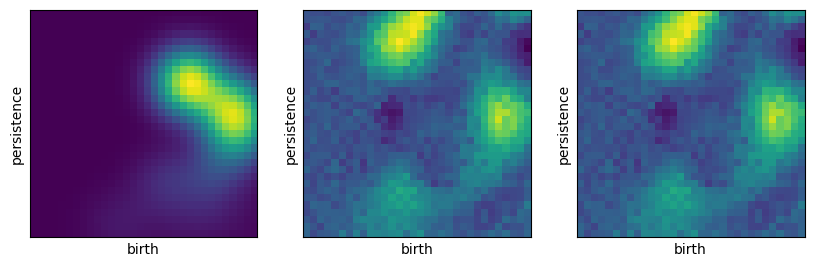

In [ ]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize = (10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_pim(dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_pim(dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/pim_3.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

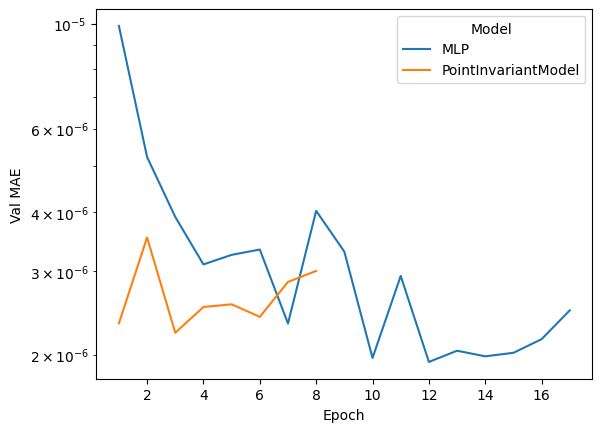

In [ ]:
#@title [RUN] Visualisation
tikz = False
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
plt.yscale('log')
if tikz:
    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/graph_mlp_pim.tex')
else:
    plt.show()

# Step 4: Simple MLP With convolution

In [ ]:
class ConvMLP(nn.Module):
    def __init__(self, output_dim=1024):
        super(ConvMLP, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        # self.conv3 = nn.Conv1d(128, output_dim, 1)
        self.conv3 = nn.Linear(128, output_dim)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.collapse = nn.MaxPool1d(nb_points)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = x.unsqueeze(2)

        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x))).squeeze()
        x = self.activation(self.bn3(self.conv3(x)))

        x = x.transpose(0, 1).squeeze()
        x = self.collapse(x).squeeze()
        return x

In [ ]:
model_conv_mlp = ConvMLP()
model_name_conv_mlp = type(model_conv_mlp).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_conv_mlp, 
    model_name_conv_mlp, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=20
)
RESULTS[model_name_conv_mlp] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for ConvMLP, training on 1000 samples for 20 epochs.

Model architecture:
ConvMLP(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Linear(in_features=128, out_features=1024, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 143104

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000366, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 010, LR: 0.001000, Loss: 0.0000039, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 015, LR: 0.000900, Loss: 0.0000022, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 020, LR: 0.000810, Loss: 0.000002

<ipython-input-23-0c91720e3c6f>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


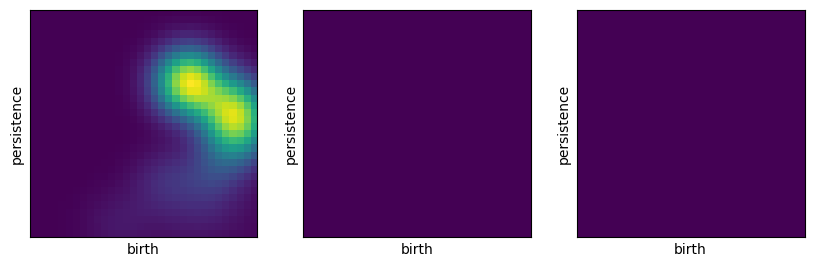

In [ ]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize=(10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_conv_mlp(dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_conv_mlp(dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/conv_mlp_3.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

# Step 5: Invariant MLP with convolution

In [ ]:
class Conv_PointInvariantModel(nn.Module):
    def __init__(self, input_dim=64, output_dim=1024):
        super(Conv_PointInvariantModel, self).__init__()
        
        self.emb_layer = DistanceLayer(input_dim)
        self.conv1 = nn.Conv1d(input_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, output_dim, 1)

        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(output_dim)

        self.collapse = nn.MaxPool1d(nb_points)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.emb_layer(x))
        x = x.unsqueeze(2)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = x.transpose(0, 1)
        x = self.collapse(x.squeeze()).squeeze()
        return x

In [ ]:
model_conv_pim = Conv_PointInvariantModel()
model_name_conv_pim = type(model_conv_pim).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_conv_pim, 
    model_name_conv_pim, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=20
)
RESULTS[model_name_conv_pim] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for Conv_PointInvariantModel, training on 1000 samples for 20 epochs.

Model architecture:
Conv_PointInvariantModel(
  (emb_layer): DistanceLayer()
  (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 142720

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000453, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 010, LR: 0.000900, Loss: 0.0000108, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 015, LR: 0.000900, Loss: 0.0000021, Val MAE: 0.0000024, Test MAE: 0.0000022
Epoch: 020, LR: 0.000810, Loss: 0.0000156, Val MAE: 0.0000024, Test MAE: 0.0000022

Done! Training took 6.63 mins. Best valid

<ipython-input-26-c16091101df6>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


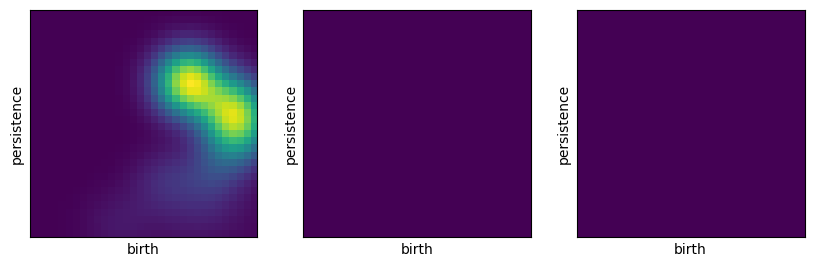

In [ ]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize=(10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_conv_pim(dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_conv_pim(dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/conv_pim.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

# Step 6: PointNet

In [ ]:
# coded inspired from https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        x = x.unsqueeze(2)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = self.relu(self.bn4(self.fc1(x)))
        x = self.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

In [ ]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform


    def forward(self, x):
        trans = self.stn(x)
        x = x.unsqueeze(2)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 0, keepdim=True)[0]
        x = x.view(-1, 1024)
        return x.squeeze()


In [ ]:
model_pointnet = PointNetfeat()
model_name_pointnet = type(model_pointnet).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_pointnet, 
    model_name_pointnet, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
RESULTS[model_name_pointnet] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for PointNetfeat, training on 1000 samples for 100 epochs.

Model architecture:
PointNetfeat(
  (stn): STN3d(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=9, bias=True)
    (relu): ReLU()
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): Conv1d

<ipython-input-30-6acb68051bb7>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


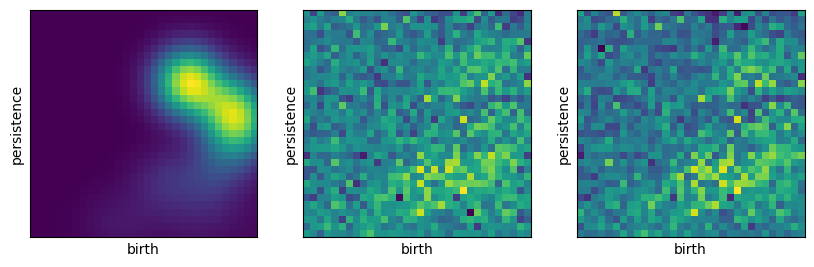

In [ ]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize=(10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_pointnet(dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_pointnet(dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/pointnet.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

# Step 7: Invariance unit tests

In [ ]:
def permute_points(data, perm):    
    return data[perm]

def permutation_invariance_unit_test(module, dataloader):
    it = iter(dataloader)
    data_x = next(it)[0].squeeze()

    # Forward pass on original example
    out_1 = module(data_x)

    # Create random permutation
    perm = torch.randperm(nb_points)
    data_x = permute_points(data_x, perm)

    # Forward pass on permuted example
    out_2 = module(data_x)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def random_orthogonal_matrix(dim=3):
    Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
    return Q


def rot_trans_invariance_unit_test(module, dataloader):
    module.eval()

    it = iter(dataloader)
    data_x = next(it)[0].squeeze()

    out_1 = module(data_x)   

    Q = random_orthogonal_matrix(dim=3)
    t = torch.rand(3)
    data_x = torch.matmul(data_x, Q) + t

    out_2 = module(data_x)

    return torch.allclose(out_1, out_2, atol=1e-03)

In [ ]:
dataloader = DataLoader(train_dataset, shuffle=True)

model = MLP(input_dim=3, output_dim=1024, hidden_dim=64, num_layers=2)
# Permutation and Rotation invariance unit test 
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(model).__name__} rotation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!\n")

model = PointInvariantModel(input_dim=nb_points, output_dim=1024, hidden_dim=64, num_layers=2)
# Permutation and Rotation invariance unit test 
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(model).__name__} rotation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!\n")

model = ConvMLP()
# Permutation and Rotation invariance unit test 
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(model).__name__} rotation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!\n")

model = Conv_PointInvariantModel()
# Permutation and Rotation invariance unit test 
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(model).__name__} rotation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!\n")

model = PointNetfeat()
# Permutation and Rotation invariance unit test 
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")
print(f"Is {type(model).__name__} rotation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!\n")

Is MLP permutation invariant? --> True!
Is MLP rotation invariant? --> False!

Is PointInvariantModel permutation invariant? --> False!
Is PointInvariantModel rotation invariant? --> True!

Is ConvMLP permutation invariant? --> True!
Is ConvMLP rotation invariant? --> False!

Is Conv_PointInvariantModel permutation invariant? --> False!
Is Conv_PointInvariantModel rotation invariant? --> True!

Is PointNetfeat permutation invariant? --> True!
Is PointNetfeat rotation invariant? --> False!



# Step 8: Comparaison of MAE evolution

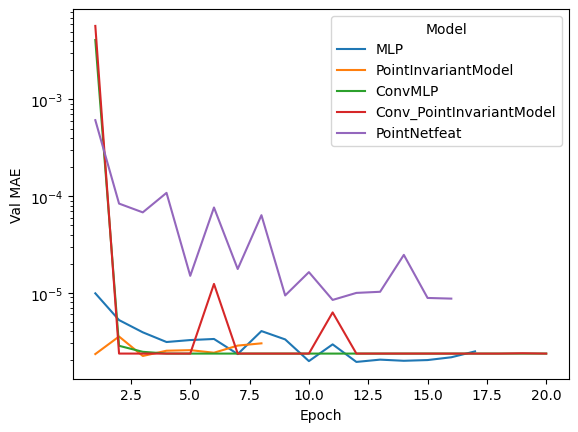

In [ ]:
#@title [RUN] Visualisation
tikz = False
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
plt.yscale('log')
if tikz:
    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/graph_mae_all.tex')
else:
    plt.show()

# Step 9: Time to compute persistence image

In [ ]:
averaging_number = 100

class MyShapeNetTest(Dataset):
    def __init__(self, transform = None):
        super(MyShapeNetTest, self).__init__()
        
        path = './shapenet'
        dataset = ShapeNet(path, transform = transform)

        self.data = [torch.Tensor(dataset[i].pos) for i in range(averaging_number)]
        random.shuffle(self.data)

    def len(self):
        return len(self.data)

    def get(self, index):
        return self.data[index]

In [ ]:
nbs = [(i+1) * 20 for i in range(50)]
times = []
for nb_pts in nbs:
    preprocess = T.Compose([Select_Points(nb_pts), Normalisation()]) # Select_Points Reduce number of points in each point cloud to reduce computations. Normalisation of the points
    dataset_test = MyShapeNetTest(transform = preprocess)
    t = time.time()
    for i in range(averaging_number):
        pimgr.transform(rips.fit_transform(dataset_test[i])[1])
    t = (time.time() - t)/averaging_number
    times.append(t)

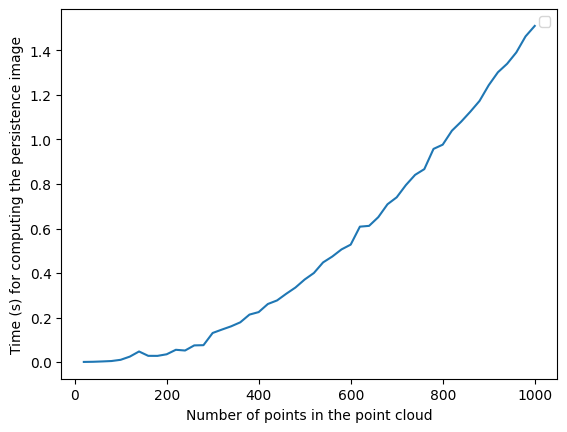

In [ ]:
tikz = False
fig, ax = plt.subplots(1, 1)
ax.plot(nbs, times)
plt.xlabel("Number of points in the point cloud")
plt.ylabel("Time (s) for computing the persistence image")
ax.legend(loc='best')
if tikz:
    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/time_computing_pi.tex')
else:
    plt.show()

# Step 10: Experiment with a much simpler dataset to analyse the impact of the dataset choice.

In [ ]:
# Parameters
low_x, high_x = 0, 1 
low_y, high_y = 0, 1

noise_low_x, noise_high_x = -0.01, 0.01
noise_low_y, noise_high_y = -0.01, 0.01

nb_points = 200
nb_datasets = 1000
noise = 0.2

In [ ]:
def datasets(nb_points_ml, nb_datasets_ml, noise):
    datasets_circle = []
    datasets_nocircle = []
    for i in range(nb_datasets_ml):
        # no circle dataset
        points_x = np.random.uniform(low_x, high_x, nb_points_ml)
        points_y = np.random.uniform(low_y, high_y, nb_points_ml)
        dataset = list(zip(points_x, points_y))
        datasets_nocircle.append(dataset)

        # circle dataset
        points_x = np.random.uniform(low_x, high_x, int(nb_points_ml * noise))
        points_y = np.random.uniform(low_y, high_y, int(nb_points_ml * noise))
        noise_circle_x = np.random.uniform(noise_low_x, noise_high_x, int(nb_points_ml * (1 - noise)))
        noise_circle_y = np.random.uniform(noise_low_y, noise_high_y, int(nb_points_ml * (1 - noise)))
        theta = np.random.uniform(0, 2 * np.pi, int(nb_points_ml * (1 - noise)))
        circle_x = [0.5 + 0.25 * np.cos(theta[i]) + noise_circle_x[i] for i in range(int(nb_points_ml * (1 - noise)))]
        circle_y = [0.5 + 0.25 * np.sin(theta[i]) + noise_circle_y[i] for i in range(int(nb_points_ml * (1 - noise)))]
        x = list(points_x) + circle_x
        y = list(points_y) + circle_y
        dataset = list(zip(x, y))
        datasets_circle.append(dataset)
    return datasets_circle, datasets_nocircle

In [ ]:
# TDA tools
rips = Rips() # Rips complex for speed
pimgr = PersistenceImager(pixel_size=0.015625, birth_range=(0.0, 0.5), pers_range=(0.0, 0.5)) # resolution 32x32 

# # Parameters to fine-tune for the dataset (no canonical choice)
pimgr.kernel_params = {'sigma': 0.01}

# no need to use a weight to enhance topological features :
# pimgr.weight = persistence
# pimgr.weight_params = {'n': 2.0}

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [ ]:
datasets_circle, datasets_nocircle = datasets(nb_points, nb_datasets, noise)
dataset2 = datasets_circle + datasets_nocircle

In [ ]:
class TopologicalDataset(Dataset):
    def __init__(self, transform = None):
        super(TopologicalDataset, self).__init__()
        
        self.data = [(torch.Tensor(dataset2[i]), torch.Tensor(pimgr.transform(rips.fit_transform(torch.Tensor(dataset2[i]))[1]).flatten())) for i in range(len(dataset2))]
        random.shuffle(self.data)

    def len(self):
        return len(self.data)

    def get(self, index):
        return self.data[index]

In [ ]:
top_dataset = TopologicalDataset()

In [ ]:
print(f"Total number of samples: {len(top_dataset)}.")

# Split datasets (Small dataset for experiment)
train_dataset_top = top_dataset[:1000]
val_dataset_top = top_dataset[1000:1500]
test_dataset_top = top_dataset[1500:2000]

print(f"Created dataset splits with {len(train_dataset_top)} training, {len(val_dataset_top)} validation, {len(test_dataset_top)} test samples.")

# Create dataloaders
train_loader_top = DataLoader(train_dataset_top, shuffle=True)
val_loader_top = DataLoader(val_dataset_top, shuffle=False)
test_loader_top = DataLoader(test_dataset_top, shuffle=False)

Total number of samples: 2000.
Created dataset splits with 1000 training, 500 validation, 500 test samples.


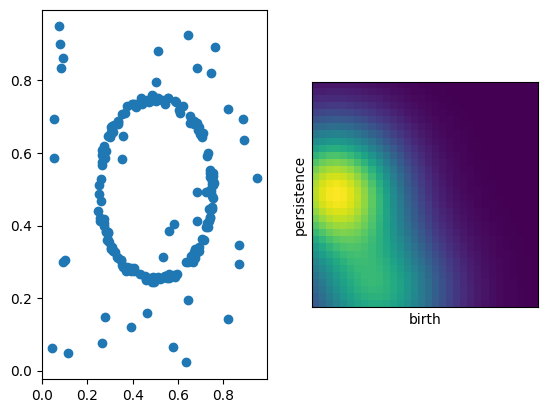

In [ ]:
#@title [RUN] Visualisation

# Pointcloud
index = 143

fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(top_dataset[index][0][:, 0], top_dataset[index][0][:, 1])

# Persistence image (ground truth to predict)
ax = fig.add_subplot(122)
pimgr.plot_image(top_dataset[index][1].reshape(pimgr.resolution), ax)
plt.show()

# Model adpated to this simple dataset

In [50]:
model_mlp_top = MLP(input_dim=2, output_dim=1024, hidden_dim=64, num_layers=3)
model_name_mlp_top = type(model_mlp_top).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_mlp_top, 
    model_name_mlp_top, 
    train_loader_top,
    val_loader_top, 
    test_loader_top,
    n_epochs=100
)
RESULTS[model_name_mlp_top] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MLP, training on 1000 samples for 100 epochs.

Model architecture:
MLP(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1024, bias=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 70912

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000005, Val MAE: 0.0000005, Test MAE: 0.0000003
Epoch: 010, LR: 0.001000, Loss: 0.0000004, Val MAE: 0.0000005, Test MAE: 0.0000003
Epoch: 015, LR: 0.001000, Loss: 0.0000003, Val MAE: 0.0000003, Test MAE: 0.0000003
Epoch: 020, LR: 0.001000, Loss: 0.0000003, Val MAE: 0.0000002, Test MAE: 0.0000002
Epoch: 025, LR: 0.001000, Loss: 0.0000002, Val MAE: 0.0000003, Test MAE: 0.0000002
Epoch: 026, LR: 0.001000, Loss: 0.0000002, Val MAE: 0.0000003, Test MAE: 0.0000002

Done! Training

<ipython-input-50-1dd84b78de00>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


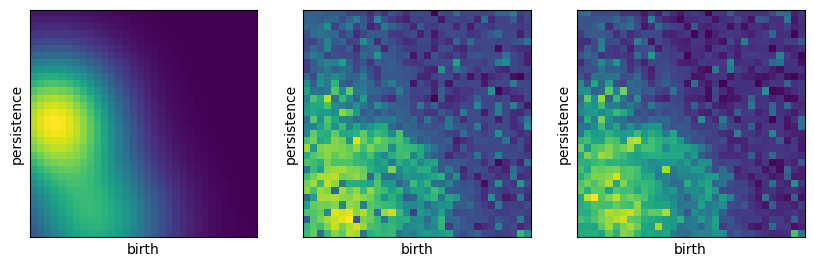

In [51]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize=(10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_mlp_top(top_dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = top_dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_mlp_top(top_dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/mlp_top.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()

In [52]:
model_pim_top = PointInvariantModel(input_dim=nb_points, output_dim=1024, hidden_dim=64, num_layers=3)
model_name_pim_top = type(model_pim_top).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model_pim_top, 
    model_name_pim_top, 
    train_loader_top,
    val_loader_top, 
    test_loader_top,
    n_epochs=100
)
RESULTS[model_name_pim_top] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for PointInvariantModel, training on 1000 samples for 100 epochs.

Model architecture:
PointInvariantModel(
  (emb_layer): DistanceLayer()
  (input_layer): Linear(in_features=200, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1024, bias=True)
  (collapse): MaxPool1d(kernel_size=200, stride=200, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
)
Total parameters: 83584

Start training:
Epoch: 005, LR: 0.001000, Loss: 0.0000002, Val MAE: 0.0000003, Test MAE: 0.0000002
Epoch: 010, LR: 0.001000, Loss: 0.0000002, Val MAE: 0.0000004, Test MAE: 0.0000001
Epoch: 014, LR: 0.001000, Loss: 0.0000002, Val MAE: 0.0000003, Test MAE: 0.0000001

Done! Training took 3.10 mins. Best validation MAE: 0.0000001, corresponding test MAE: 0.0000001.


<ipython-input-52-1ec70e60c02c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


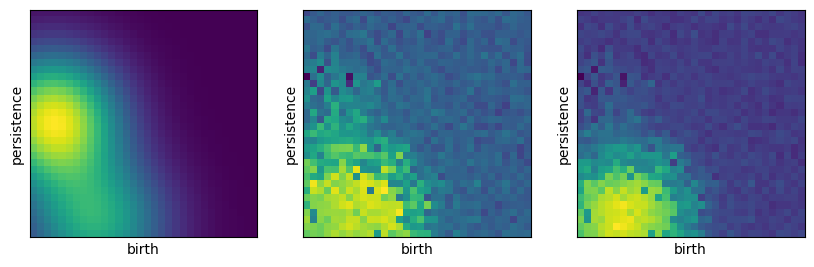

In [53]:
#@title [RUN] Visualisation

tikz = False
fig = plt.figure(figsize=(10, 10))
index = 143

# Persistence image (ground truth to predict)

pi_predicted = model_pim_top(top_dataset[index][0]).detach().numpy().reshape(pimgr.resolution)
pi_groundtruth = top_dataset[index][1].detach().numpy().reshape(pimgr.resolution)
pi_predicted_0 = model_pim_top(top_dataset[0][0]).detach().numpy().reshape(pimgr.resolution)

if tikz:
    ax = fig.add_subplot(311)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(312)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(313)
    pimgr.plot_image(pi_predicted_0, ax)

    tikzplotlib_fix_ncols(fig)
    tikzplotlib.save('/content/drive/MyDrive/pim_top.tex')
else:
    ax = fig.add_subplot(131)
    pimgr.plot_image(pi_groundtruth, ax)
    ax = fig.add_subplot(132)
    pimgr.plot_image(pi_predicted, ax)
    ax = fig.add_subplot(133)
    pimgr.plot_image(pi_predicted_0, ax)
    plt.show()